In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
plt.ion()   

In [2]:
#规范化数据
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'CUB_200_2011'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

#load8个样本
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()
use_gpu

False

In [3]:
dataset_sizes

{'train': 5994, 'test': 5794}

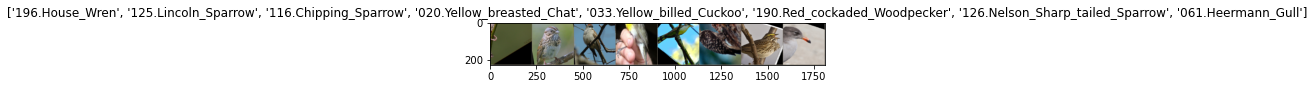

In [4]:
#表示张量
def imshow(inp, title=None):
    #转换矩阵
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

inputs, classes = next(iter(dataloders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
#正常的训练模型函数
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        #每个epoch都有训练和验证阶段
        for phase in ['train', 'test']:
            if phase == 'train':
                #scheduler.step()
                #训练模式
                model.train(True)  
            else:
                #评估模式
                model.train(False)  

            running_loss = 0.0
            running_corrects = 0

            #迭代数据
            for data in dataloders[phase]:
                inputs, labels = data

                if use_gpu:
                    #gpu进行运算
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                #渐变参数归零
                optimizer.zero_grad()

                # 前向传播
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # 训练阶段后向传播并优化参数
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            #找出测试结果最好的
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model_ft.state_dict(),'optim':optimizer_ft.state_dict()}
                torch.save(state,'CUB_200_2011/point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    #load最好的模型权重，便于下次使用
    model.load_state_dict(best_model_wts)
    return model

#可视化少量图像预测的函数
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()
    

    for i, data in enumerate(dataloders['test']):
        inputs, labels = data
        #print(labels)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #print(labels)
        #_, lab = torch.max(labels.data, 1)
        outputs = model(inputs)
        #print(outputs)
        _, preds = torch.max(outputs.data, 1)
        #print(preds)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [6]:
#从torchvision模型加载预先训练（在image net上训练）的resnet18模型
model_ft = models.resnet18(pretrained=True) 
num_ftrs = model_ft.fc.in_features
#将最后一层改为200
model_ft.fc = nn.Linear(num_ftrs, 200)      

#gpu可用就使用它
if use_gpu:                                 
    model_ft = model_ft.cuda()       
model_ft = model_ft.float()
#loss function
criterion = nn.CrossEntropyLoss()           

#参数的优化
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

In [7]:
#已保存的检查点进行加载
checkpoint = torch.load('CUB_200_2011/point_resnet_best.pth',map_location=torch.device('cpu'))
model_ft.load_state_dict(checkpoint['model'])
optimizer_ft.load_state_dict(checkpoint['optim'])

In [ ]:
#训练模型（50个epochs）
model_ft = train_model(model_ft, criterion, optimizer_ft,num_epochs=50)

Epoch 0/49
----------


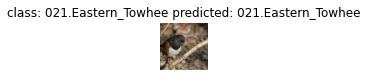

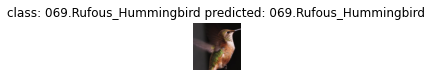

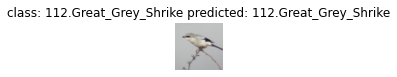

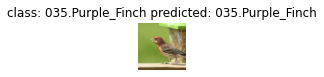

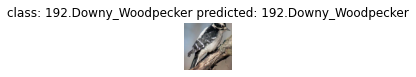

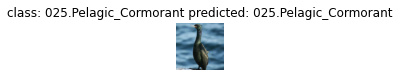

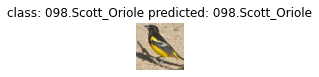

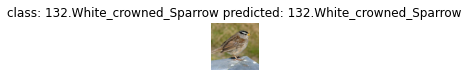

In [8]:
#选择八个测试集进行预测并可视化
visualize_model(model_ft)